In [15]:
import os
import pygmt
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns

from scipy.interpolate import make_interp_spline
from scipy.stats import pearsonr
from scipy.stats import spearmanr

%config InlineBackend.figure_formats = ['svg']

import matplotlib.pyplot as plt
%matplotlib inline

Load the simulation:

In [5]:
df2 = pd.read_csv('data/bristol_sim_list.csv',sep=',')
df2

,model,time,name
0,teXpb3,265,265Ma
1,teXpa,262,262Ma
2,texPz,256,256Ma
3,texPy,252,252Ma
4,texPx,244,245Ma
5,texPw2,239,240Ma
6,texPv1,233,234Ma
7,texPu1,232,232Ma
8,texPt1,227,227Ma
9,texPs1,222,222Ma


In [6]:
df = pd.read_csv('data/simdata.csv',sep='\t')
df

,Simulation Name,Brief Description,Fuller Description,Owner,Model Descriptors,Total Length of Run (in years),Averaging period (in years),Spinup period (in years),Coastline name and code numner,CO2 (in ppmv),CH4 (in ppbv),N2O (in ppbv),CFC11 (in pptv),CFC12 (in pptv),Computer used for simulation,Compiler used for simulation,Date of first entry in database,Date of most recent modification to entry in database
0,teXyb,265_1_MaBP,This is the 265.1 Ma simulation using the Scot...,ggpjv,"HadCM3L, MOSES2_1, TRIFFID_dyn",500,100,400,"Capi, 444",524.00,760,270,0,0,bc4,Intel_v17_0.1_bc4,2019_11_25_08_19,2019_11_25_08_19
1,teXya,262_5_MaBP,This is the 262.5 Ma simulation using the Scot...,ggpjv,"HadCM3L, MOSES2_1, TRIFFID_dyn",500,100,400,"Capi, 443",526.00,760,270,0,0,bc4,Intel_v17_0.1_bc4,2019_11_25_08_19,2019_11_25_08_19
2,texYz,256_0_MaBP,This is the 256.0 Ma simulation using the Scot...,ggpjv,"HadCM3L, MOSES2_1, TRIFFID_dyn",500,100,400,"Wuch, 442",531.00,760,270,0,0,bc4,Intel_v17_0.1_bc4,2019_11_25_08_19,2019_11_25_08_19
3,texYy,252_0_MaBP,This is the 252.0 Ma simulation using the Scot...,ggpjv,"HadCM3L, MOSES2_1, TRIFFID_dyn",500,100,400,"Indu, 441",534.00,760,270,0,0,bc4,Intel_v17_0.1_bc4,2019_11_25_08_19,2019_11_25_08_19
4,texYx,244_6_MaBP,This is the 244.6 Ma simulation using the Scot...,ggpjv,"HadCM3L, MOSES2_1, TRIFFID_dyn",500,100,400,"Anis, 440",540.00,760,270,0,0,bc4,Intel_v17_0.1_bc4,2019_11_25_08_19,2019_11_25_08_19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,texpe,019_5_MaBP,This is the 19.5 Ma simulation using the Scote...,ggpjv,"HadCM3L, MOSES2_1, TRIFFID_dyn",2000,100,1900,"Burd, 395",338.28,760,270,0,0,bc4,Intel_v17_0.1_bc4,2018_12_14_10_49,2018_12_16_21_13
104,texpd,014_9_MaBP,This is the 14.9 Ma simulation using the Scote...,ggpjv,"HadCM3L, MOSES2_1, TRIFFID_dyn",2000,100,1900,"Lang, 394",310.19,760,270,0,0,bc4,Intel_v17_0.1_bc4,2018_12_14_10_49,2018_12_16_21_13
105,texpc,010_5_MaBP,This is the 10.5 Ma simulation using the Scote...,ggpjv,"HadCM3L, MOSES2_1, TRIFFID_dyn",2000,100,1900,"Tort, 393",299.40,760,270,0,0,bc4,Intel_v17_0.1_bc4,2018_12_14_10_49,2018_12_16_21_13
106,texpb,004_0_MaBP,This is the 4.0 Ma simulation using the Scotes...,ggpjv,"HadCM3L, MOSES2_1, TRIFFID_dyn",2000,100,1900,"Zanc, 392",298.33,760,270,0,0,bc4,Intel_v17_0.1_bc4,2018_12_14_10_49,2018_12_16_21_13


In [9]:
times = df2['time'].values
smoothedCO2 = df['CO2 (in ppmv)'].values[:54]
fosterCO2 = df['CO2 (in ppmv)'].values[54:]

In [11]:
def sCurve(time, data, nbfine=542, nbcoarse=50):
    
    ftime = np.linspace(time.min(), time.max(), nbfine)
    
    interp = make_interp_spline(time, np.asarray(data), k=3)
    
    return ftime,interp(ftime)

In [12]:
time, sCO2 = sCurve(-times, smoothedCO2)
time, fCO2 = sCurve(-times, fosterCO2)

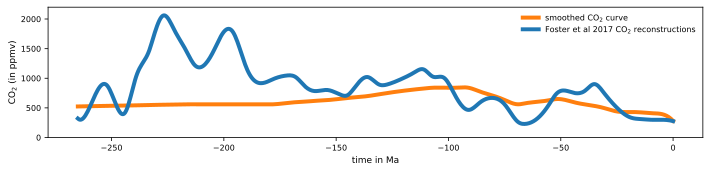

In [14]:
fig, ax1 = plt.subplots(figsize=(10, 2.5), dpi=300)

ax1.plot(time, sCO2, '-', color='tab:orange', zorder=2, lw=4, 
         label='smoothed CO$_2$ curve')
ax1.set_ylabel('CO$_2$ (in ppmv)', color='k', fontsize=9)

plt.xlabel('time in Ma', fontsize=9)
# plt.xlim([-540,0])
plt.ylim([0,2200])
ax1.plot(time, fCO2, color='tab:blue', lw=4, label='Foster et al 2017 CO$_2$ reconstructions')

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(frameon=False, prop={'size': 8}, loc=1)

fig.tight_layout()
plt.savefig('trend_CO2.pdf')
plt.show()

## CO2 database

Foster, G., Royer, D. & Lunt, D. Future climate forcing potentially without precedent in the last 420 million years. Nat Commun 8, 14845 (2017). https://doi.org/10.1038/ncomms14845

Supplementary Data 2. LOESS fit to the CO2 data set in Sup. Data 1. 

In [59]:
fosterData = pd.read_excel('data/41467_2017_BFncomms14845_MOESM2875_ESM.xlsx',skiprows=1)
fosterTime = fosterData['Age (Ma)'][:531]
fosterCO2lw = fosterData['lw95%'][:531]
fosterCO2up = fosterData['up95%'][:531]
fosterCO2mean = fosterData['pCO2 probability maximum'][:531]

Supplementary Data 1. Phanerozoic CO2 compilation used in analyses

In [97]:
LIVERWORTS = pd.read_excel('data/LIVERWORTS.xlsx')
LIVERWORTS_co2 = LIVERWORTS['CO2'][1:].to_list()
LIVERWORTS_age = (-LIVERWORTS['Age'][1:]).to_list()

ALKENONES = pd.read_excel('data/ALKENONES.xlsx')
ALKENONES_co2 = ALKENONES['CO2'][1:].to_list()
ALKENONES_age = (-ALKENONES['Age'][1:]).to_list()

MARINEBORON = pd.read_excel('data/MARINEBORON.xlsx')
MARINEBORON_co2 = MARINEBORON['CO2'][1:].to_list()
MARINEBORON_age = (-MARINEBORON['Age'][1:]).to_list()

PALEOSOLS = pd.read_excel('data/PALEOSOLS.xlsx')
PALEOSOLS_co2 = PALEOSOLS['CO2'][1:].to_list()
PALEOSOLS_age = (-PALEOSOLS['Age'][1:]).to_list()

STOMATA = pd.read_excel('data/STOMATA.xlsx')
STOMATA_co2 = STOMATA['CO2'][1:].to_list()
STOMATA_age = (-STOMATA['Age'][1:]).to_list()

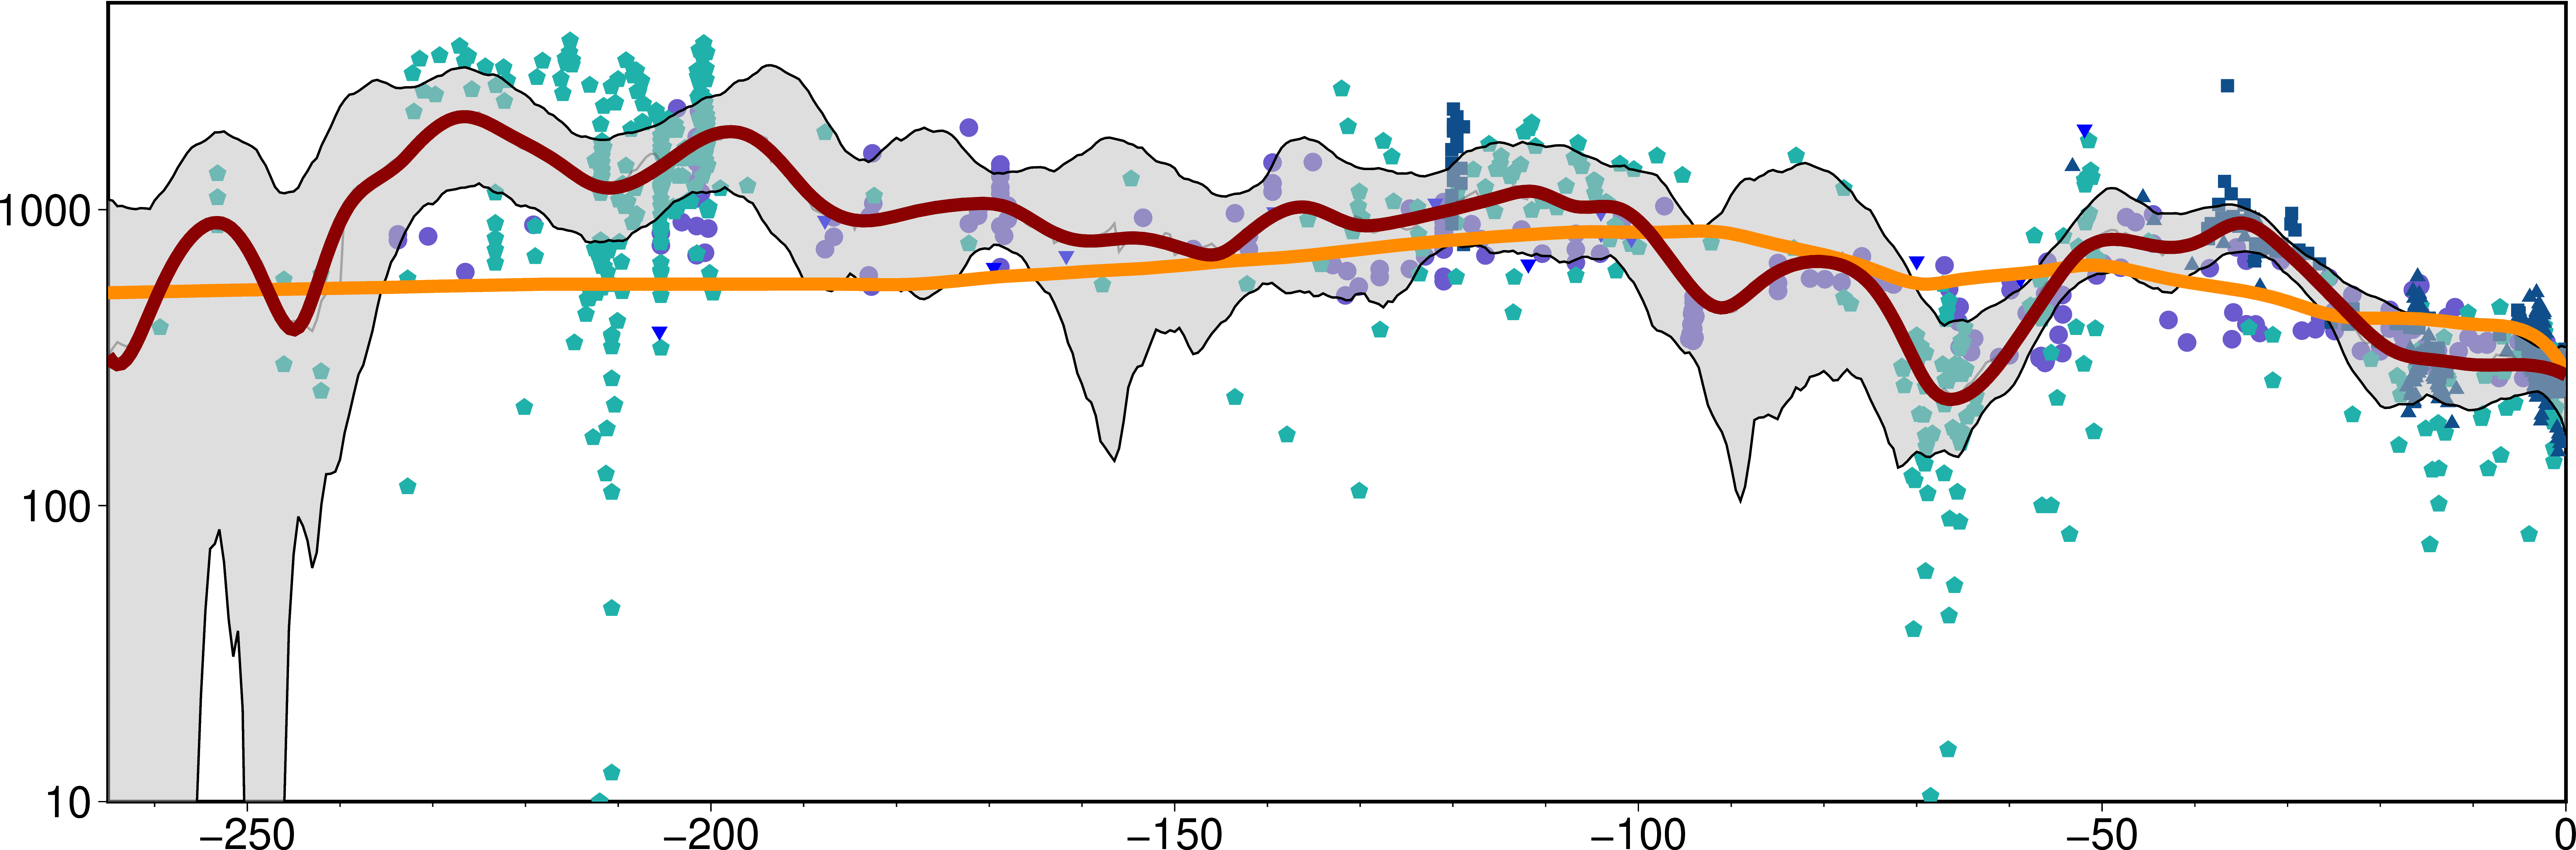

In [127]:
fig = pygmt.Figure()
pygmt.config(
    MAP_FRAME_WIDTH="0.5p",
    MAP_FRAME_TYPE="fancy",
)
font = "4p,Helvetica-Bold"

df_bound = pd.DataFrame(
    data={
        "x": -fosterTime,
        "y": fosterCO2mean,
        "y_bound_low": fosterCO2lw,
        "y_bound_upp": fosterCO2up,
    }
)
with pygmt.config(FONT='20p,Helvetica,black'):
    fig.basemap(region=[-265, 0, 10, 5000], projection="X40c/13cl", 
                frame=['af',"ya100"])
    
    
    fig.plot(
        x=STOMATA_age,
        y=STOMATA_co2,
        style="c0.3c", 
        fill="slateblue", 
#         pen="1p,black",
    )
    
    fig.plot(
        x=PALEOSOLS_age,
        y=PALEOSOLS_co2,
        style="n0.3c", 
        fill="lightseagreen", 
#         pen="1p,black",
    )
    
    fig.plot(
        x=MARINEBORON_age,
        y=MARINEBORON_co2,
        style="t0.3c", 
        fill="dodgerblue4", 
#         pen="1p,black",
    )
    
    fig.plot(
        x=ALKENONES_age,
        y=ALKENONES_co2,
        style="s0.3c", 
        fill="dodgerblue4", 
#         pen="1p,black",
    )
    
    
    fig.plot(
        x=LIVERWORTS_age,
        y=LIVERWORTS_co2,
        style="i0.3c", 
        fill="blue", 
#         pen="1p,black",
    )
    
    fig.plot(data=df_bound, close="+b+p0.5p,gray30,dashed", 
             fill="gray@50", pen="1p,gray30",transparency=60)
    
    fig.plot(x=-fosterTime,y=fosterCO2lw,transparency=0,pen="1p,black")
    fig.plot(x=-fosterTime,y=fosterCO2up,transparency=0,pen="1p,black")
    
    fig.plot(x=time,y=sCO2,transparency=0,pen="6p,darkorange")
    fig.plot(x=time,y=fCO2,transparency=0,pen="6p,darkred")
    
fig.show(dpi=500, width=1000)